In [33]:
import numpy as np
import pandas as pd


from sklearn.metrics import r2_score, mean_squared_error, make_scorer

import warnings

warnings.filterwarnings('ignore')

# 1. Define Metric SMAPE

In [34]:


def smape(y_true, y_pred):
    y_true = y_true + 1
    y_pred = y_pred + 1
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

# 2. Load Train and Sample Test Data

## 2.1 Protein data

In [35]:
proteins = pd.read_csv('train_proteins.csv')


## 2.2 Peptides data

In [36]:
peptides = pd.read_csv('train_peptides.csv')


## 2.3 Clinical data

In [37]:
clinical = pd.read_csv('train_clinical_data.csv')


In [38]:
supplemental_clinical_data = pd.read_csv('supplemental_clinical_data.csv')
supplemental_clinical_data = supplemental_clinical_data
df_sup= pd.concat([clinical,supplemental_clinical_data]).drop(columns = 'upd23b_clinical_state_on_medication').reset_index(drop=True)

In [39]:
from sklearn.decomposition import PCA
def get_pca_df(df,df_proteins,df_peptides,comp):
    df_prot_pept = df_proteins.merge(df_peptides[['visit_id', 'UniProt', 'Peptide','PeptideAbundance']], on = ['visit_id','UniProt'], how = 'left')
    df_all = pd.merge(df_prot_pept,df, how = 'left')
    # df_all = df_all.drop(columns = 'upd23b_clinical_state_on_medication')

    protein_pivot = df_proteins.pivot(index='visit_id',columns = 'UniProt', values = 'NPX').rename_axis(columns=None).reset_index()
    peptide_pivot = df_peptides.pivot(index='visit_id',columns = 'Peptide', values = 'PeptideAbundance').rename_axis(columns=None).reset_index()
    df_prot_pept = protein_pivot.merge(peptide_pivot, on = ['visit_id'], how = 'left')

    df_all = pd.merge(df,df_prot_pept, how = 'left')
    # df_all = df_all.drop(columns = 'upd23b_clinical_state_on_medication')
    col_df_all = df_prot_pept.drop('visit_id',axis = 1).columns.to_list()
    
    df_all[col_df_all] = df_all[col_df_all].fillna(0)

    pca = PCA(n_components=1)
    
    principalComponents = pca.fit_transform(df_all[col_df_all])
    # print(f'Explained variance for {comp} componed is {pca.explained_variance_ratio_}')
    df_pca = pd.DataFrame(principalComponents,columns=['PCA_1'])
    for name in ['P16070', 'O15240' , 'LVFFAEDVGSNK']:
        col_df_all.remove(name)
    drop_columns = df_all[col_df_all].columns.to_list()
    df_ = pd.concat([df_all.drop(drop_columns,axis = 1),df_pca],axis=1)

    return df_


In [40]:
df_pca_train = get_pca_df(df_sup,proteins,peptides,1)
df_pca_train.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,O15240,P16070,LVFFAEDVGSNK,PCA_1
0,55_0,55,0,10.0,6.0,15.0,NaN,177775.0,302429.0,57869.1,3.436546e+08
1,55_3,55,3,10.0,7.0,25.0,NaN,0.0,0.0,0.0,-7.328657e+07
2,55_6,55,6,8.0,10.0,34.0,NaN,165638.0,302785.0,54670.1,2.970491e+08
3,55_9,55,9,8.0,9.0,30.0,0.0,0.0,0.0,0.0,-7.328657e+07
4,55_12,55,12,10.0,10.0,41.0,0.0,151073.0,324369.0,64743.5,3.355597e+08


# 5. Training

In [41]:
df_0_1 = df_pca_train[['visit_id','updrs_1','patient_id','visit_month','PCA_1','O15240']].dropna(subset = ['updrs_1']).reset_index(drop=True)
df_0_2 = df_pca_train[['visit_id','updrs_2','patient_id','visit_month','PCA_1','O15240']].dropna(subset = ['updrs_2']).reset_index(drop=True)
df_0_3 = df_pca_train[['visit_id','updrs_3','patient_id','visit_month','PCA_1','O15240']].dropna(subset = ['updrs_3']).reset_index(drop=True)
df_0_3 = df_0_3[df_0_3['updrs_3'] != 0].reset_index(drop=True)
df_0_4 = df_pca_train[['visit_id','updrs_4','patient_id','visit_month','PCA_1','O15240']].dropna(subset = ['updrs_4']).reset_index(drop=True)

df_lst = [df_0_1, df_0_2, df_0_3, df_0_4]

In [42]:
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
train_smape_scores_list = []
def objective(trial):
    """
    Objective function to be passed to Optuna
    It also does Cross-Validation
    """
    param = {
        'random_state':42,
        'n_estimators': trial.suggest_int('n_estimators',10,300,step=10),
        'criterion': trial.suggest_categorical('criterion',choices=['squared_error']),
        'max_depth' : trial.suggest_int('max_depth',1,10),
        'max_features': trial.suggest_categorical('max_features',choices=['sqrt']),
        'max_samples': trial.suggest_float('max_samples',0.2,0.95, step=0.05),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,20, step = 3),
    }
    model_params = param

    rf.set_params(**model_params)

#     kf = KFold(n_splits = 10, shuffle = True, random_state = 42)

    gkf = GroupKFold(n_splits = 18)
    groups = train_0['patient_id']
    X = train_0.drop([f'updrs_{i+1}'],axis = 1)
    y = train_0[f'updrs_{i+1}']
    for fold, (train_index, test_index) in enumerate(gkf.split(X, y, groups)):
        train_0.loc[test_index, "kfold"] = fold
        # fold_data = pd.merge(df_visit_id,train_0,on='patient_id')
    smape_scores = []
    train_smape_scores=[]
    metrics_new = []
    for fold in range(18):
        df_train = train_0[train_0.kfold != fold]
        df_valid = train_0[train_0.kfold == fold]
        feature_cols = train_0.drop(['visit_id','patient_id','kfold',f'updrs_{i+1}'],axis=1).columns.tolist()

        target_cols = [ f'updrs_{i+1}']
        X_train = df_train[feature_cols]
        y_train = df_train[target_cols].values.ravel()
        X_val  = df_valid[feature_cols]
        y_val = df_valid[target_cols].values.ravel()
        rf.fit(X_train, y_train)
        train_smape_score = smape(y_train, np.round(rf.predict(X_train)))
        smape_score = smape(y_val, np.round(rf.predict(X_val)))
        trainVal_auc = train_smape_score - smape_score

        smape_scores.append(smape_score)
        train_smape_scores.append(train_smape_score)
        train_smape_scores_list.append(train_smape_score)
#         metrics_to_improve = smape_score/abs(trainVal_auc)
        metrics_new.append(abs(trainVal_auc))
#         print(f'train score {(train_smape_score)} , val score {(smape_score)}, difference for score {(abs(trainVal_auc))}')
    metrics_Mean_Diff = abs(np.mean(train_smape_scores) - np.mean(smape_scores))

    return metrics_Mean_Diff

In [43]:
import optuna
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
model = {}
# mms_store = {}
# mms = MinMaxScaler()

smape_avg=[]
val_smape = []

def smape_plus_one(y_true, y_pred):
    epsilon = 1e-10
    denominator = np.abs(y_true) + np.abs(y_pred) + epsilon
    diff = np.abs(y_true - y_pred) / denominator
    smape = 2.0 * np.mean(diff)
    smape_plus_one = smape + 1.0
    return smape_plus_one
X_test_list = []
X_train_list = []
y_test_list = []
y_train_list = []
for i in range(3):
    print('--------------------------------------------------------')
    print( "#" * 17, "Model",  i + 1, "#" * 17)

    train_0 = df_lst[i]

    # scale_col = ['NPX_mean','NPX_median', 'Abe_mean', 'Abe_median']
    # train_0[scale_col] = mms.fit_transform(train_0[scale_col])

    rf = RandomForestRegressor(random_state=42,criterion=smape_plus_one)
    # rf = xgb.XGBRegressor(random_state= 42)
    # lr = LinearRegression()


    # Bayesian Optimization
    study = optuna.create_study(direction = 'minimize',sampler = optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials = 100)

    # Best hyperparameters
    best_params = study.best_params
    rf.set_params(**best_params)
    X_all = train_0.drop(columns = ['visit_id','patient_id',f'updrs_{i+1}','kfold'])
    # X = train_0[['visit_month']+ scale_col]
    y_all = train_0[f'updrs_{i+1}']

    total_rows = X_all.shape[0]

    split_index = int(3/4 * total_rows)
    X = X_all.iloc[:split_index]
    X_test = X_all.iloc[split_index:]
    X_test_list.append(X_test)
    X_train_list.append(X)
    y = y_all.iloc[:split_index]
    y_test = y_all.iloc[split_index:]
    y_test_list.append(y_test)
    y_train_list.append(y)

    Val = train_0[train_0['kfold']==1]
    X_val = Val.drop(columns = ['visit_id','patient_id',f'updrs_{i+1}','kfold'])
    y_val = Val[f'updrs_{i+1}']


    rf.fit(X, y)
    smape_avg.append(smape(y, np.round(rf.predict(X))))
    val_smape.append(smape(y_val, np.round(rf.predict(X_val))))
    # print(f"Train smape: {(smape(y, np.round(rf.predict(X))))}")
    # print(f"Validation smape on {Val['patient_id'].nunique()} patients: {(smape(y_val, np.round(rf.predict(X_val))))}")
    # print( "#"  * 45)

    model[i] = rf
    # mms_store[i] = mms
smape_avg.append(41.93)
val_smape.append(smape(y, np.zeros(y.shape[0])))
print(f"SMAPE AVEGARE FOR ALL IS {np.mean(smape_avg)}")
print(f"VAL SMAPE AVEGARE FOR 51 patients IS {np.mean(val_smape)}")

[I 2023-08-04 16:06:37,220] A new study created in memory with name: no-name-35a0dcb7-627d-4ae8-b101-e623e8883a8e


--------------------------------------------------------
################# Model 1 #################


[I 2023-08-04 16:06:39,429] Trial 0 finished with value: 0.8365136289260136 and parameters: {'n_estimators': 120, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 0.75, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.8365136289260136.
[I 2023-08-04 16:06:39,945] Trial 1 finished with value: 0.11315132323018418 and parameters: {'n_estimators': 50, 'criterion': 'squared_error', 'max_depth': 2, 'max_features': 'sqrt', 'max_samples': 0.2, 'min_samples_leaf': 19}. Best is trial 1 with value: 0.11315132323018418.
[I 2023-08-04 16:06:41,925] Trial 2 finished with value: 0.22788399392561587 and parameters: {'n_estimators': 190, 'criterion': 'squared_error', 'max_depth': 8, 'max_features': 'sqrt', 'max_samples': 0.2, 'min_samples_leaf': 19}. Best is trial 1 with value: 0.11315132323018418.
[I 2023-08-04 16:06:44,522] Trial 3 finished with value: 0.30325083051207713 and parameters: {'n_estimators': 250, 'criterion': 'squared_error', 'max_depth': 3, 'ma

SMAPE AVEGARE FOR ALL IS 49.24912393538362
VAL SMAPE AVEGARE FOR 51 patients IS 97.28051577450842


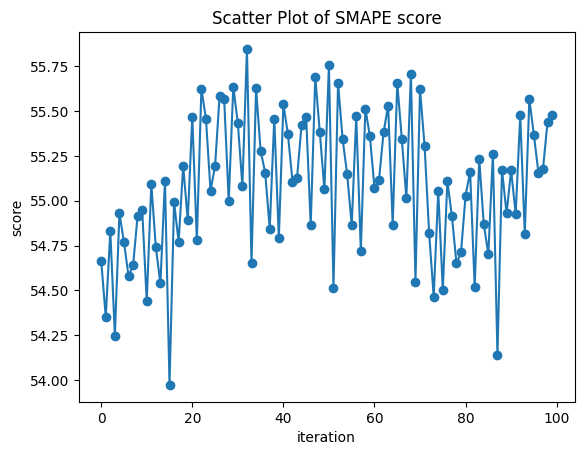

In [53]:
import random
train_smape_scores_list=train_smape_scores_list[:100]
plt.plot(train_smape_scores_list)

# 添加标题和轴标签
x_values = range(len(train_smape_scores_list))

# 绘制散点图
plt.scatter(x_values, train_smape_scores_list)

# 添加标题和轴标签
plt.title('Scatter Plot of SMAPE score')
plt.xlabel('iteration')
plt.ylabel('score')

# 显示图形
plt.show()

In [49]:

(smape(y, np.zeros(y.shape[0])))

132.57547655279248

In [ ]:
result = []
for i in range(3):
    model_to_predict = model[i]
    predictions = model_to_predict.predict(X_test_list[i])
    result.append(predictions)

In [ ]:
true_labels_list = []
predicted_labels_list = []
for i in range(3):
    true = []
    predict = []
    for j in y_test_list[i]:
        true.append(float(j))
    for j in result[i]:
        predict.append(float(j))
    true_labels_list.append(true)
    predicted_labels_list.append(predict)

In [ ]:
from sklearn.linear_model import LinearRegression
X_test_list = []
X_train_list = []
y_test_list = []
y_train_list = []
for i in range(3):
    train_0 = df_lst[i]
    X_all = train_0.drop(columns = ['visit_id','patient_id',f'updrs_{i+1}'])
    # X = train_0[['visit_month']+ scale_col]
    y_all = train_0[f'updrs_{i+1}']

    total_rows = X_all.shape[0]

    split_index = int(3/4 * total_rows)
    X = X_all.iloc[:split_index]
    X_test = X_all.iloc[split_index:]
    X_test_list.append(X_test)
    X_train_list.append(X)
    y = y_all.iloc[:split_index]
    y_test = y_all.iloc[split_index:]
    y_test_list.append(y_test)
    y_train_list.append(y)
# lr = LinearRegression()
# lr.fit(X_train_list[0], y_train_list[0])
# model_to_predict2 = lr
# predictions2 = model_to_predict2.predict(X_train_list[0])
# print(r2_score(y_train_list[0], predictions2))
rf = RandomForestRegressor(random_state=30,criterion='squared_error',n_estimators=90,min_samples_leaf=1)
rf.fit(X_train_list[0], y_train_list[0])
model_to_predict = rf
predictions = model_to_predict.predict(X_train_list[0])
r2 = r2_score(y_train_list[0], predictions)
mse = mean_squared_error(y_train_list[0], predictions)
r2

In [ ]:
from sklearn.metrics import mean_squared_error
for i in range(3):
    mse = mean_squared_error(true_labels_list[i], predicted_labels_list[i])
    print(mse)


In [ ]:
from sklearn.metrics import r2_score
for i in range(3):
    r2 = r2_score(true_labels_list[i], predicted_labels_list[i])
    print(r2)